In [1]:
import math as mt
import cmath as cmt
import numpy as np
import scipy as sp
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import quad
import warnings

In [4]:
%matplotlib notebook
# Unit: MeV
# Channels only Neutron-Proton
steps_real = int(1e2)+1
steps_imag = int(1e2)+1
e_range_real = np.linspace( 938.272+939.565 , 1900., steps_real)
e_range_imag = np.linspace( 20., -20., steps_imag)
step_real=e_range_real[1]-e_range_real[0]
step_imag=e_range_imag[1]-e_range_imag[0]
e_mesh_real , e_mesh_imag= np.meshgrid(e_range_real,e_range_imag)
e_mesh_full = e_mesh_real + e_mesh_imag*1.j

def kernel_mod(q):
    return q**2

# Experiment values
a_exp = 5.424/197
r0_exp = 1.759/197
r1_exp = 0.040/197**3
a_d_exp = -20.0/193


r_core = 1.0/197  # Hard core range
r_well = 2.0/197   # Well range

mass_p = np.array([938.9185,938.9185])
mass_n = np.array([938.9185,938.9185])
mass_N = 938.9185
mass_ch = mass_p + mass_n
mass_pi = (139.570 + 134.976)/2
threshold = 2*mass_N
erg_binding = 2.224
mass_exp = threshold - erg_binding
mass_0 = 1876.3595


# Gauge, energy cut, renormalization parameter
lambda_cut = 150.
a_C = mass_N/2/np.pi**2 * (-lambda_cut)
a_D = - 2 * lambda_cut / mass_N
a_reno = 1.512347083013356
mu_reno = 2000.

ga = 1.26

# Saved Parameters
c0_th = 1/( mass_N/4/np.pi/a_exp + a_C)
c1_th = r0_exp*mass_N/8/np.pi*c0_th**2
c2_th = mass_N/4/np.pi*r1_exp* c0_th**2 + c1_th**2/c0_th
c_opep_th_0 = mass_pi**2/4*c0_th
c_opep_th_1 = - mass_pi**4 / 8 * c1_th
c2_th_save =None #(r1_exp + a_exp * r0_exp**2 /4)* 4 * mt.pi * a_exp**2/mass_N
c2_trivial_save = None #(a_exp * r0_exp**2 /4)* 4 * mt.pi * a_exp**2/mass_N

# Branch Cut and system parameters
opepCut=10
num_of_ch = 2
cut_default = 1
sheet_other = 0
sheet_downright = -1

# Initialization
data_type = { "r":np.float64 , "c":np.complex128 }
qbar = np.zeros( num_of_ch , dtype = data_type["c"])
#erg_p = np.zeros( num_of_ch , dtype = data_type["c"])
#ohm = np.zeros( num_of_ch , dtype = data_type["c"])
#s = np.zeros( num_of_ch , dtype = data_type["c"])
#V_2pion = np.zeros( [num_of_ch , num_of_ch] , dtype = data_type["c"])

#if lambda_cut<2*mass_pi:
#    raise ValueError('Low Lambda Cut in Hard Cut Regulation')
    
#############################
# General Purpose Functions #
#############################
def para_beta(beta):
    c0_beta = 1/(mass_N/4/np.pi/a_exp- mass_N*beta/8/np.pi)
    c1_beta = (r0_exp*mass_N/8/np.pi - 3*mass_N/8/np.pi/beta)*c0_beta**2
    c2_beta = (mass_N*r1_exp/4/np.pi + c1_beta**2/c0_beta**3 + 5*mass_N/8/np.pi/beta**3)*c0_beta**2
    return [['constant',c0_beta,c1_beta,c2_beta],['form' , beta]]

def p_core(k,r):
    return 4*mt.pi/k*( -1/k*r*cmt.cos(k*r) + 1/(k**2)*cmt.sin(k*r) )

def hardcore_para(para):
    if para[0]!='hardcore':
        raise('wrong command sequence',para)
    tmp = 3/4/mt.pi/para[2][0]**3 * (c0_th - 4* mt.pi* para[1][1]*para[1][0]**3/3)
    return [['hardcore',[para[1][0],para[1][1]],[para[2][0],tmp]]]
def kronecker(a,b):
    if a==b:
        return 1
    else:
        return 0
def squarediff(a,b):
    if len(a)!=len(b):
        print('wrong length config')
        return None
    return np.sum(np.square(np.subtract(a,b)))
def newton_method( f, x=[0.,1.,None] , eps = 1e-8, max_iter = 10000):
    i_iter = 0
    x_new = [0,0,None]
    fx_new = [0,0,None]
    fx = [ f(x[0]), f(x[1]) , None]
    if abs(fx[0])>abs(fx[1]):
        x_new = [x[1],x[0],None]
        fx_new = [fx[1],fx[0],None]
        x=x_new
        fx=fx_new
        x_new = [0,0,None]
        fx_new = [0,0,None]
    while i_iter < max_iter:
        flag_sign = np.sign(fx[0])*np.sign(fx[1])
        x[2] = ( abs(fx[0])*x[1] - flag_sign*abs(fx[1])*x[0] ) / ( abs(fx[0]) - flag_sign*(abs(fx[1])))
        fx[2] = f(x[2])
        arg_sort = np.argsort( [ abs(fx[0]) , abs(fx[1]) , abs(fx[2]) ] )
        if arg_sort[2] == 2:
            print('Error: Non-Linear or No Zero')
            print(x[0],x[1],x[2])
            return x[2]
        for tmp in range(3):
            if arg_sort[tmp] == 0:
                x_new[0] = x[tmp]
                fx_new[0] = fx[tmp]
            elif arg_sort[tmp] == 1:
                x_new[1] = x[tmp]
                fx_new[1] = fx[tmp]
        x=x_new
        fx=fx_new
        x_new = [0,0,None]
        fx_new = [0,0,None]
        if abs(fx[0])<eps:
            return x[0]
        i_iter = i_iter + 1
    print('reach iteration maximum, eps = ' , fx[0])
    return x[0]
def type_regulation(inQ, outQ, Gtype):
    if inQ != 'k' and inQ != 'erg':
        print('wrong inarg type')
        return False
    if (outQ != 'kcot' and outQ != 'T' and outQ != 'invT' and outQ != 'G' and outQ!='Z0'
             and outQ!='V' and outQ!='Gdiff' and outQ!='Vtilde'):
        print('wrong outarg type')
        return False
    if Gtype != 'full' and Gtype != 'approx':
        print('wrong Gtype')
        return False
    return True
#############################
# Experiment Comparison     #
#############################
def kcot_exp(k):
    one_over_a = 1./a_exp
    r0 = r0_exp
    r1 = -0.48/(197.**3)
    return (- one_over_a + 0.5*r0*(abs(k)**2))

def T_exp(k):
    return 1+(2.j*k)/kcot_exp(k)-1.j*k
#############################
# Sheet Related Functions   #
#############################
def odd_or_even(num):
    if type(num) != int:
        print('Warning: odd_even not well defined',num)
    tmp=int(num)
    if tmp%2 == 0:
        return 'even'
    else:
        return 'odd'
# sheet number go from 0
def log_sheet(num , sheet, cut = cut_default):
    if cut == -1:
        return cmt.log(num)+2.j*cmt.pi*sheet
                
    if num.imag>=0:
        place='up'
    else:
        place='down'
        
    if cut==1:
        if place == 'up':
            return cmt.log(num)+2.j*cmt.pi*(sheet)
        if place == 'down':
            return cmt.log(num)+2.j*cmt.pi*(sheet+1)
        
    print('wrong cut config',cut,place)
    return cmt.nan
def sqrt_sheet(num , sheet, cut = cut_default):
    sheet = odd_or_even(sheet)
    if cut == -1:
        if sheet == 'even':
            return cmt.sqrt(num)
        else:
            if sheet == 'odd':
                return -cmt.sqrt(num)
            else:
                print('wrong sheet config',sheet)
                return cmt.nan     
    if num.imag>=0:
        place='up'
    else:
        place='down'
    if cut==1:
        if sheet == 'even' and place == 'up':
            return cmt.sqrt(num)
        if sheet == 'even' and place == 'down':
            return -cmt.sqrt(num)
        if sheet == 'odd' and place == 'up':
            return -cmt.sqrt(num)
        if sheet == 'odd' and place == 'down':
            return cmt.sqrt(num)
    print('wrong cut config',cut,sheet,place)
    return cmt.nan
def log_choose(num, erg, ch):
    if erg.real > mass_ch[ch] and erg.imag <0 and num.real > 0:
        return log_sheet( num, sheet_downright)
    else:
        return log_sheet( num, sheet_other)
def log_choose2(num, erg, ch):
    if num.real > 0 and num.imag <0:
        return log_sheet( num, sheet_downright)
    else:
        return log_sheet( num, sheet_other)
def sqrt_choose(num, erg, ch):
    if erg.real > mass_ch[ch] and erg.imag <0:
        return sqrt_sheet( num, sheet_downright)
    else:
        return sqrt_sheet( num, sheet_other)

#############################
# Auxiliary Function        #
#############################
def f_V_2pion(theta,k):
    V_2pion_tmp = 0
    omega_tmp = cmt.sqrt(k**2 + 4 * mass_pi**2)
    s_tmp = cmt.sqrt(lambda_cut**2 - 4 * mass_pi**2)
    q_tmp = 2*k*mt.sin(theta/2)
    mtrx_G_pion[0][0] = omega_tmp/2/q_tmp*log_choose(
            (lambda_cut**2 * omega_tmp**2 + q_tmp**2 * s_tmp **2 + 2 * lambda_cut * q_tmp * omega_tmp * s_tmp)
            /
            (4*mass_pi**2 * (lambda_cut**2 + q_tmp**2) ),erg,ch)
    V_2pion_tmp = para[3]*mtrx_G_pion[0][0]* ( 4*mass_pi**2 * (5*ga**4 - 4*ga**2-1) +
                q_tmp**2 * (23*ga**4 - 10*ga**2-1)+
                48* ga**4 * mass_pi**4 / (4 * mass_pi**2 + q_tmp**2)
                )*mt.sin(theta)
    return V_2pion_tmp
def mod(A,type_mtrx,direction,p):
# T->Ttilde is direction 1
    mtrx_P = np.array([[1,0],[0,kernel_mod(p)]])
    mtrx_P_inv = np.linalg.inv(mtrx_P)
    tmp = 0
    if direction == 1:
        tmp = 1
    if direction == -1:
        tmp = -1
        
    if type_mtrx =='G':
        tmp = -1 * tmp
    elif type_mtrx == 'T' or type_mtrx == 'V':
        tmp = tmp
    else:
        raise('wrong matrix name in modification')
    
    if tmp == 1:
        return np.matmul(np.matmul(mtrx_P_inv,A),mtrx_P_inv)
    if tmp == -1:
        return np.matmul(np.matmul(mtrx_P,A),mtrx_P)
    
#############################
# Main Calculation Function #
#############################
def calc( inarg , para, inQ , outQ , Gtype = 'approx', flag_TypeChecked = False, flag_mod = True):
#   para[] : parameter in potential,
#        ['constant' , constant ,k^2, k^4]
#        ['inverse' , k^-1 , k^-2]
#        ['hardcore' , [range , depth], [range, depth]]
#        ['opep' , One Pion Exchange LO, OPEP NLO , opepCut]
#        ['tpep' , Two Pion Exchange]
#        ['dch' , SD coupling k2, SD coupling k4 , D channel, bool_effective_potential]
#        ['form', beta]
#   bool_effective_potential: True -> second channel incooperated through effective potential
#                             False - > second channel exist explicitly
#   inQ : 'k' , 'erg' 
#   inarg : dim-1 list
#   outQ: 'kcot', 'T', 'invT', 'G', 'Vtilde', 'Z0'
#   outarg: dim-2 list
#   Gtype: 'full', 'approx'
    flag_constant = -1
    if flag_TypeChecked == False:
        if type_regulation(inQ,outQ,Gtype) == False:
            print('Type Regulation Fail')
            return None
    qbar = np.zeros( num_of_ch , dtype = data_type["c"])
    mtrx_G = np.zeros( [num_of_ch , num_of_ch], dtype = data_type["c"])
    V = np.zeros( [num_of_ch , num_of_ch] , dtype = data_type["c"])
    if inQ == 'k':
        qbar = inarg
        erg = cmt.sqrt(qbar[0]**2 + mass_p[0]**2) + cmt.sqrt(qbar[0]**2 + mass_n[0]**2)
    if inQ == 'erg':
        erg = inarg[0]
        for ch in range(num_of_ch):
            qbar[ch] = sqrt_choose( (erg**2 - (mass_p[ch] - mass_n[ch])**2) * (erg**2 - (mass_p[ch] + mass_n[ch])**2), erg, ch)/2./erg
    if outQ == 'Gdiff':
        Gtype = 'full'
    for ch in range(num_of_ch):
        if Gtype == 'full':
            mtrx_G[ch][ch] = 4.*mass_n[ch]*mass_p[ch]/((4. * mt.pi)**2) * (
                a_D +
                (mass_p[ch]**2 - mass_n[ch]**2 + erg**2)/(2. * erg**2) * cmt.log((mass_p[ch]/mass_n[ch])**2) + 
                qbar[ch] / erg *(
                    + log_choose(erg**2 - (mass_n[ch]**2 - mass_p[ch]**2) + 2.*erg*qbar[ch], erg, ch)
                    + log_choose(erg**2 + (mass_n[ch]**2 - mass_p[ch]**2) + 2.*erg*qbar[ch], erg, ch)
                    - log_choose(-erg**2 + (mass_n[ch]**2 - mass_p[ch]**2) + 2.*erg*qbar[ch], erg, ch)
                    - log_choose(-erg**2 - (mass_n[ch]**2 - mass_p[ch]**2) + 2.*erg*qbar[ch], erg, ch)
                    )
                )
        if Gtype == 'approx':
#            print("a_C",a_C)
            mtrx_G[ch][ch] = a_C - mass_N / 4. / cmt.pi * 1.j * qbar[0]

    for pot in range(len(para)):
            if para[pot][0] == 'constant':
                V[0][0] = V[0][0] + para[pot][1] + para[pot][2] * qbar[0]**2 + para[pot][3] * qbar[0]**4
                flag_constant = pot
                continue
            if para[pot][0] == 'inverse':
                V[0][0] = V[0][0] + para[pot][1] * (erg-threshold)**(-1) + para[pot][2] * (erg-threshold)**(-2)
                continue
            if para[pot][0] == 'hardcore':
                V[0][0] = V[0][0] + (para[pot][1][1]*p_core(qbar[0],para[pot][1][0])
                                     +para[pot][2][1]*p_core(qbar[0],para[pot][2][0]))
                continue
            if para[pot][0] == 'opep':
                V[0][0] = V[0][0] + para[pot][1] * (
                        log_choose2( (4*qbar[0]**2+mass_pi**2) / mass_pi**2 , erg , 0)/qbar[0]**2)
                if para[pot][3] == 2:
                    V[0][0] = V[0][0] + para[pot][1] * (- 4 / mass_pi**2 + 8 / mass_pi**4 *qbar[0]**2)
                if para[pot][3] == 1:
                    V[0][0] = V[0][0] + para[pot][1] * (- 4 / mass_pi**2)
                if para[pot][3] != 0 and para[pot][3] != 1 and para[pot][3] != 2:
                    raise('Error: opepCut = ',para[pot][3])
                continue
                    
            if para[pot][0] == 'tpep':
                V[0][0] = V[0][0] + para[pot][1] * mt.sqrt(mt.pi)*quad(f_V_2pion,0,mt.pi,args = (qbar[0]))
                continue
                
            if para[pot][0] == 'dch':
                if (para[pot][4] == True and num_of_ch != 1) or (para[pot][4] == False and num_of_ch == 1):
                    raise('bool_effective_potential',para[3][2],'\n num_of_ch',num_of_ch)
                if para[pot][4] == True:
                    V0N = para[pot][1]*qbar[0]**2+para[pot][2]*qbar[0]**4
                    VNN = para[pot][3]*qbar[0]**4
                    GN = mtrx_G[0][0]
                    V[0][0] = V[0][0] + V0N * GN/(1-VNN*GN) * V0N
                if para[pot][4] == False:
                    V[0][1]=para[pot][1]*(qbar[0]**2)+para[pot][2]*(qbar[0]**4)
                    V[1][0]=V[0][1]
                    V[1][1]=para[pot][3]*qbar[0]**4
                continue
                
            if para[pot][0] == 'form':
                beta = para[pot][1]
                erg_tmp=erg-2*mass_N
                for ch in range(num_of_ch):
                    mtrx_G[ch][ch] = 1/2/np.pi**2 * mass_N * np.pi * beta**3/4/(sqrt_choose(erg_tmp*mass_N,erg,ch)+1.j*beta)**2
                continue    
                
            raise('parameter command sequence error')
    
    
    if outQ == 'Gdiff':
        mtrx_G_approx = np.zeros( [num_of_ch , num_of_ch], dtype = data_type["c"])
        for ch in range(num_of_ch):
            mtrx_G_approx[ch][ch] = - mass_N / 4. / cmt.pi*1.j*qbar[0]
        return mtrx_G - mtrx_G_approx 
    if flag_mod == True and num_of_ch ==2 :
        V = mod(V,'V',1,qbar[0])
        mtrx_G = mod(mtrx_G,'G',1,qbar[0])
###############################
    if outQ == 'G':
        return mtrx_G
    if outQ == 'V':
        return V
    if outQ == 'Z0':
        return [[( erg - mass_0 ) / ( 1/para[flag_constant][1] - mtrx_G[0][0])]]
    if outQ == 'Vtilde':
        if flag_constant != -1:
            Vtilde = V[0][0] - para[flag_constant][1]
        else:
            Vtilde = V[0][0]
        return [[Vtilde]]
    if Gtype == 'full':
        mtrx_invT =  (np.linalg.inv(V) - mtrx_G)
    if Gtype == 'approx':
        mtrx_invT =  (np.linalg.inv(V) - mtrx_G)
        
    if outQ == 'invT':
        return mtrx_invT
    mtrx_T = np.linalg.inv(mtrx_invT)
    if outQ == 'T':
        return mtrx_T
    if outQ == 'kcot':
        kcot= - 4* cmt.pi / mass_N / mtrx_T[0][0]+ 1.j * qbar[0]
        return [[kcot]]
    

#############################
# Compositeness Calculation #
#############################
def deriv_complex( center , outQ, step_imag = 1e-8 , step_real = 1e-8, para = [0,0,0] ,  Gtype = 'approx',
                  channel=[0,0],flag_mod = True ):
    if type_regulation('erg',outQ,Gtype) == False:
        print('Type Regulation Fail')
        return None
    data = np.zeros([3,3], dtype = data_type["c"])
    pt = np.zeros([8], dtype = data_type["c"])
    points = [[ center + step_imag * 1.j - step_real*1 , center + step_imag * 1.j + step_real*0, center + step_imag * 1.j + step_real*1 ]
            ,[center - step_real*1 , center , center + step_real*1 ]
            ,[center - step_imag * 1.j - step_real*1 , center - step_imag * 1.j + step_real*0, center - step_imag * 1.j + step_real*1]]
    for tmp1 in range(3):
        for tmp2 in range(3):
            data[tmp1][tmp2] = calc([points[tmp1][tmp2]], para ,'erg',outQ, Gtype = Gtype,flag_mod=flag_mod)[channel[0]][channel[1]]
    pt[0]= (data[1,2] - data[1,1])/(step_real*1+step_imag*0.j)
    pt[1]= (data[0,2] - data[1,1])/(step_real*1+step_imag*1.j)
    pt[2]= (data[0,1]- data[1,1])/(step_real*0+step_imag*1.j)
    pt[3]= (data[0,0]- data[1,1])/(step_real*-1+step_imag*1.j)
    pt[4]= (data[1,0]- data[1,1])/(step_real*-1+step_imag*0.j)
    pt[5]= (data[2,0]- data[1,1])/(step_real*-1+step_imag*-1.j)
    pt[6]= (data[2,1]- data[1,1])/(step_real*0+step_imag*-1.j)
    pt[7]= (data[2,2]- data[1,1])/(step_real*1+step_imag*-1.j)
#    print(pt1,pt2,pt3,pt4,pt5,pt6,pt7,pt8)
#    print('diff',pt1-pt4)
    deriv_1avg = np.sum(pt)/8
    deriv_1dif = np.amax(pt)-np.amin(pt)
#    print('1st order derivative', deriv_1avg, 'percentage difference', np.abs(deriv_1dif/deriv_1avg))  
    if deriv_1avg!=0:
        if np.abs(deriv_1dif/deriv_1avg)>0.1:
            warnings.warn("Derivative Accuracy lower than 10%")
            print(outQ,'derivative detail',pt)
    return deriv_1avg

def deriv2_complex( center , outQ, step_imag = 1e-5 , step_real = 1e-5, para = [0,0,0] ,  Gtype = 'approx',
                  channel=[0,0],flag_mod = True ):
    if type_regulation('erg',outQ,Gtype) == False:
        print('Type Regulation Fail')
        return None
    data = np.zeros([3], dtype = data_type["c"])
    points = [center - step_real*1 , center , center + step_real*1]
    for tmp in range(3):
        data[tmp] = calc([points[tmp]], para ,'erg',outQ, Gtype = Gtype,flag_mod=flag_mod)[channel[0]][channel[1]]
    deriv_2 = (data[0]+data[2]-2*data[1])*(step_real**-2)
    return deriv_2

def deriv_real( center , outQ , step_real = 1e-3, para = [0,0,0] ,  Gtype = 'full',
                  channel=[0,0],flag_mod = True ):
    if type_regulation('erg',outQ,Gtype) == False:
        print('Type Regulation Fail')
        return None
    data = np.zeros([3], dtype = data_type["c"])
    points = [center-step_real,center,center+step_real]
    for tmp in range(3):
        data[tmp] = calc([points[tmp]], para ,'erg',outQ, Gtype = Gtype,flag_mod=flag_mod)[channel[0]][channel[1]]
    first = (data[2]-data[0])/(2*step_real)
    second = (data[2]-2*data[1]+data[0])/(step_real**2)
    return [first,second]

def integral_contour(contour_center , len_edge = 0.5 , steps_edge = int(1e7), para = [0,0,0] ,
                     Gtype = 'approx',channel = [0,0],flag_mod=True):
    steps_peri = int(steps_edge*4)
    points_contour = np.zeros( steps_peri , dtype = data_type["c"])
    dz_contour = np.zeros( steps_peri , dtype = data_type["c"])
    points_tmp = np.zeros( steps_peri , dtype = data_type["c"])
    
    end1 = contour_center-len_edge/2-len_edge*1.j/2
    end2 = contour_center+len_edge/2-len_edge*1.j/2
    end3 = contour_center+len_edge/2+len_edge*1.j/2
    end4 = contour_center-len_edge/2+len_edge*1.j/2

    points_edge1 = np.linspace(end1 , end2, int(steps_edge) , endpoint=False)
    points_edge2 = np.linspace(end2 , end3, int(steps_edge) , endpoint=False)
    points_edge3 = np.linspace(end3 , end4, int(steps_edge) , endpoint=False)
    points_edge4 = np.linspace(end4 , end1, int(steps_edge) , endpoint=False)

    points_contour = np.concatenate((points_edge1 , points_edge2 , points_edge3 , points_edge4), axis=None)
    dz_contour = np.roll(points_contour, -1) - points_contour
    points_tmp = (np.roll(points_contour, -1) + points_contour)/2
    out = 0
    
    if contour_center.real + len_edge/2 > mass_n[0]+mass_p[0] and contour_center.imag - len_edge/2 < 0:
        print('contour crossed with threshold')
    
    for tmp in range(steps_peri):
        out = out + calc([points_tmp[tmp]], para ,'erg','T', Gtype = Gtype,flag_mod=flag_mod)[channel[0]][channel[1]]*dz_contour[tmp]
    return out    

def find_pole( inarg , steps_real = int(1e3)+1 , steps_imag = int(1e1)+1 ,
              para = [0,0,0] , Gtype = 'approx',flag_mod = True, channel = [0,0]):
    e_range_real = np.linspace( inarg[0][0] , inarg[0][1] , steps_real)
    e_range_imag = np.linspace( inarg[1][0] , inarg[1][1] , steps_imag)
    step_real=e_range_real[1]-e_range_real[0]
    step_imag=e_range_imag[1]-e_range_imag[0]
    e_mesh_real , e_mesh_imag= np.meshgrid(e_range_real,e_range_imag)
    e_mesh_full = e_mesh_real + e_mesh_imag*1.j
    mtrx_T_full = np.zeros( [steps_imag, steps_real] , dtype = data_type["c"])
    mtrx_G_full = np.zeros( [steps_imag, steps_real] , dtype = data_type["c"])
    T2_full = np.zeros( [steps_imag, steps_real] , dtype = data_type["c"])
    for tmp_real in range(steps_real):
        for tmp_imag in range(steps_imag):
            mtrx_T_full[tmp_imag,tmp_real] = calc( [e_range_real[tmp_real]+e_range_imag[tmp_imag]*1.j] , para, 'erg','T', Gtype = Gtype,flag_mod = flag_mod)[channel[0]][channel[1]]
#            mtrx_G_full[tmp_imag,tmp_real] = calc( [e_range_real[tmp_real]+e_range_imag[tmp_imag]*1.j] , para, 'erg','G', Gtype = Gtype)[0][0]
            T2_full[tmp_imag,tmp_real] = abs(mtrx_T_full[tmp_imag,tmp_real])
#    print('T2_full.shape',T2_full.shape)
#    T_0=mtrx_T_full[:,:]
    ind_max = np.unravel_index(np.argmax(T2_full, axis=None), T2_full.shape)
    contour_center = e_range_real[ind_max[1]]+e_range_imag[ind_max[0]]*1.j
    print('contour_center' , contour_center)
    return contour_center

def calc_X( contour_center , len_edge = 1 , steps_edge = 1e3, step_imag_deriv = 1e-8 , step_real_deriv = 1e-8,
           para = [0], Gtype = 'approx',channel=[0,0],flag_mod = True): 
#    print('!!! IN CHANNEL #',channel[0],channel[1])
    residue = integral_contour(contour_center , len_edge = len_edge , steps_edge = steps_edge ,
            para = para , Gtype = Gtype,channel=channel,flag_mod=flag_mod)/2./cmt.pi/1.j
    derivative = deriv_complex(contour_center , 'G' ,step_imag = step_imag_deriv,step_real = step_real_deriv,
            para = para ,  Gtype = Gtype,channel=channel,flag_mod=flag_mod)
#    print('residue' , residue , 'absRes',abs(residue))
#    print('derivative' , derivative )
    if channel[0]==channel[1]:
        X = -residue*derivative
    else:
        X = 0
#    print('X',X)
#    print('absX',abs(X))
    mb_G = [
        calc([contour_center], para ,'erg' , 'G' , Gtype = Gtype,flag_mod=flag_mod)[channel[0]][channel[0]],
        calc([contour_center], para ,'erg' , 'G' , Gtype = Gtype,flag_mod=flag_mod)[channel[1]][channel[1]]
    ]
    mb_derivative_V = deriv_complex(contour_center , 'V' ,
        step_imag = step_imag_deriv , step_real = step_real_deriv ,
        para = para ,  Gtype = Gtype, channel = channel,flag_mod=flag_mod)
#    normalization_check = -1. * np.absolute(residue) * ( derivative + mb_G * mb_derivative_V * mb_G)
    normalization_check =  -residue * ( derivative*kronecker(channel[0],channel[1]) 
                                       + mb_G[0] * mb_derivative_V * mb_G[1])
    Z = -residue * mb_G[0] * mb_derivative_V * mb_G[1]
#    print('mb_G',mb_G)
#    print('Mb derivative V', mb_derivative_V)
#    print('Z',Z)
#    print('Normalization Check', normalization_check)
    return [X,Z,normalization_check]
def calc_X_chs(contour_center , len_edge = 1 , steps_edge = 1e3,
        step_imag_deriv = 1e-8 , step_real_deriv = 1e-8,  para = [0], Gtype = 'approx',flag_mod = True):
    # data=[ X{ch,ch} , Z{ch,ch} ]
    data_chs = np.zeros([2,num_of_ch,num_of_ch], dtype = data_type["c"])
    data = np.zeros([2],dtype = data_type["c"])
    normalization_check = 0
    normalization_check_chs = 0
    for ch1 in range(num_of_ch):
        for ch2 in range(num_of_ch):
            [data[0] , data[1] , normalization_check] = calc_X(contour_center , len_edge = len_edge ,
                                                    steps_edge = steps_edge, step_imag_deriv = step_imag_deriv , step_real_deriv = step_real_deriv,
                                                    para = para, Gtype = Gtype, channel = [ch1,ch2],flag_mod=flag_mod)
            for tmp in range(2):
                data_chs[tmp,ch1,ch2] = data[tmp]
            normalization_check_chs += normalization_check
    return [data_chs[0],data_chs[1],normalization_check_chs]

#############################
# Visualization Functions   #
#############################
def plot_line(inarg , inQ , outQ , steps = 101 , channel = [0,0] , Gtype = 'full' , para = [0, 0,0]
              ,real_imag = [True, True],flag_mod=True):
    if type_regulation(inQ,outQ,Gtype) == False:
        print('Type Regulation Fail')
        return None
    
    inarg_range = np.linspace( inarg[0] , inarg[1] , steps)
    out_full = np.zeros( [steps] , dtype = data_type["c"])
    for tmp_step in range(steps):
         out_full[tmp_step]= calc( [inarg_range[tmp_step]] , para ,
                                  inQ,outQ , flag_TypeChecked = True, Gtype=Gtype,flag_mod=flag_mod)[channel[0]][channel[1]]
    if real_imag[0] == True:
        plt.plot(inarg_range , out_full.real , label = outQ+'-real')
    if real_imag[1] == True:
        plt.plot(inarg_range , out_full.imag , label = outQ+'-imag')
    if real_imag[0] == False and real_imag[1] == False:
        plt.plot(inarg_range , np.absolute(out_full) , label = outQ+'-absolute')
    if outQ =='kcot':
        out_test = np.zeros( [steps] , dtype = data_type["c"])
        for tmp_step in range(steps):
            out_test[tmp_step] = kcot_exp(inarg_range[tmp_step]).real
        plt.plot(inarg_range , out_test, label = outQ+'-exp')
        plt.xlabel('q')
        plt.ylabel('qcotδ')
    plt.legend()
    
def plot_complex(inarg , inQ , outQ , steps_real = int(1e2)+1, steps_imag = int(1e2)+1 , channel = [0,0] , Gtype = 'approx' 
                 , para = [0, 0,0] , real_imag = [True, True], show_threshold = True,flag_mod=True):
# inarg[0]: real part
# inarg[1]: imag part
# real_imag: if [ False, False ], take abs value
    if type_regulation(inQ,outQ,Gtype) == False:
        print('Type Regulation Fail')
        return None
    
    inarg_range_real = np.linspace( inarg[0][0], inarg[0][1], steps_real)
    inarg_range_imag = np.linspace( inarg[1][0], inarg[1][1], steps_imag)
    step_real=inarg_range_real[1]-inarg_range_real[0]
    step_imag=inarg_range_imag[1]-inarg_range_imag[0]
    mesh_real ,mesh_imag= np.meshgrid(inarg_range_real,inarg_range_imag)
    mesh_full = e_mesh_real + e_mesh_imag*1.j
    out_full = np.zeros( [steps_imag, steps_real] , dtype = data_type["c"])
    for tmp_real in range(steps_real):
        for tmp_imag in range(steps_imag):
            out_full[tmp_imag,tmp_real] = calc( [inarg_range_real[tmp_real]+inarg_range_imag[tmp_imag]*1.j]
                                               , para,inQ,outQ,Gtype, flag_TypeChecked = True,flag_mod=flag_mod)[channel[0]][channel[1]]
    print(outQ)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    if show_threshold == True:
        line_real = np.full( 10, 2*mass_N)
        line_imag = np.linspace(0,inarg[1][0],10)
        line_z = np. zeros([10])
        ax.plot3D(line_real,line_imag, line_z, 'orangered',linewidth = 3.5)
    if real_imag[0] == True:
        ax.plot_surface(mesh_real, mesh_imag, out_full.real, rstride=1, cstride=1,
                cmap=cm.coolwarm, edgecolor='none')
#        ax.plot_wireframe(mesh_real, mesh_imag, out_full.real, color='red')
    if real_imag[1] == True:
        ax.plot_surface(mesh_real, mesh_imag, out_full.imag, rstride=1, cstride=1,
                cmap=cm.coolwarm, edgecolor='none')
#        ax.plot_wireframe(mesh_real, mesh_imag, out_full.imag, color='red')
    if real_imag[0] == False and real_imag[1] == False:
        out_full=np.absolute(out_full)
        ax.plot_surface(mesh_real, mesh_imag, out_full, rstride=1, cstride=1,
                cmap=cm.coolwarm, edgecolor='none')
#        ax.plot_wireframe(mesh_real, mesh_imag, out_full, color='red')
    ax.set_xlabel('Re(E)')
    ax.set_ylabel('Im(E)')
    ax.set_zlabel('Abs(t)')
    
def print_X_chs(inarg , steps_real = int(1e3)+1 , steps_imag = int(1e1)+1 , para = [0,0,0] , Gtype = 'approx'
               ,len_edge = 0.5 , steps_edge = 1e3, step_imag_deriv = 1e-8 , step_real_deriv = 1e-8,
                decimals_print = 3,flag_mod=True):
    print('opepCut',opepCut)
    contour_center = find_pole( inarg , para = para, steps_real = steps_real ,
                        steps_imag = steps_imag, Gtype = Gtype,flag_mod=flag_mod)
    print('V',calc( [contour_center] , para , 'erg' , 'V' , Gtype = 'approx'))
    print('G',calc( [contour_center] , para , 'erg' , 'G' , Gtype = Gtype))
    data = calc_X_chs(contour_center, len_edge = len_edge , steps_edge = steps_edge,
                      step_imag_deriv = step_imag_deriv , step_real_deriv = step_real_deriv,
                      para = para, Gtype = Gtype,flag_mod=flag_mod)
    ##np.set_printoptions(precision=3)
    print('X\n',np.around(data[0],decimals = decimals_print))
    print('Z\n',np.around(data[1],decimals = decimals_print))
    ##np.set_printoptions(precision=8)
    print('Normalization check', data[2])
    if np.abs(data[2]-1.)>0.01:
        warnings.warn('Normalization error exceed 1%')

def purterb_1(contour_center, len_edge = 1 , steps_edge = 1e3 , step_imag_deriv = 1e-8 , step_real_deriv = 1e-8,
           para = [0], Gtype = 'approx',channel=[0,0],flag_mod = True):
    qbar = np.zeros( num_of_ch , dtype = data_type["c"])
    for ch in range(num_of_ch):
        qbar[ch] = sqrt_choose( (erg**2 - (mass_p[ch] - mass_n[ch])**2) * (erg**2 - (mass_p[ch] + mass_n[ch])**2), erg, ch)/2./erg
    G_deriv = deriv_complex(contour_center , 'G' ,
        step_imag = step_imag_deriv , step_real = step_real_deriv ,
            para = para ,  Gtype = Gtype, channel = channel,flag_mod=flag_mod)
    G_deriv2 = deriv2_complex(center_center , 'G' ,
        step_imag = step_imag_deriv , step_real = step_real_deriv, para = para ,  Gtype = Gtype,
            channel=channel , flag_mod = flag_mod)
    Voverp2 = 1/4 * (2*qbar[0]/(qbar[0]**2+mass_N**2)) * deriv_complex(contour_center , 'V' ,
        step_imag = step_imag_deriv , step_real = step_real_deriv ,
            para = para ,  Gtype = Gtype, channel = channel,flag_mod=flag_mod)
    E1 = - calc( contour_center , para, 'erg' , 'Vtilde') * calc( contour_center , para, 'erg' , 'G', Gtype=Gtype)/(
        deriv_complex(contour_center , 'V' ,
        step_imag = step_imag_deriv , step_real = step_real_deriv ,
            para = para ,  Gtype = Gtype, channel = channel,flag_mod=flag_mod) *
        calc( contour_center , para, 'erg' , 'G')
        +
        deriv_complex(contour_center , 'G' ,
        step_imag = step_imag_deriv , step_real = step_real_deriv ,
            para = para ,  Gtype = Gtype, channel = channel,flag_mod=flag_mod) *
        calc( contour_center , para, 'erg' , 'V')
        )
    return Voverp2 * G_deriv - E1 * G_deriv2

[['constant', -0.0002261825329590307, 0.0, -0.0], ['form', 190.98593171027443]]
T


<IPython.core.display.Javascript object>


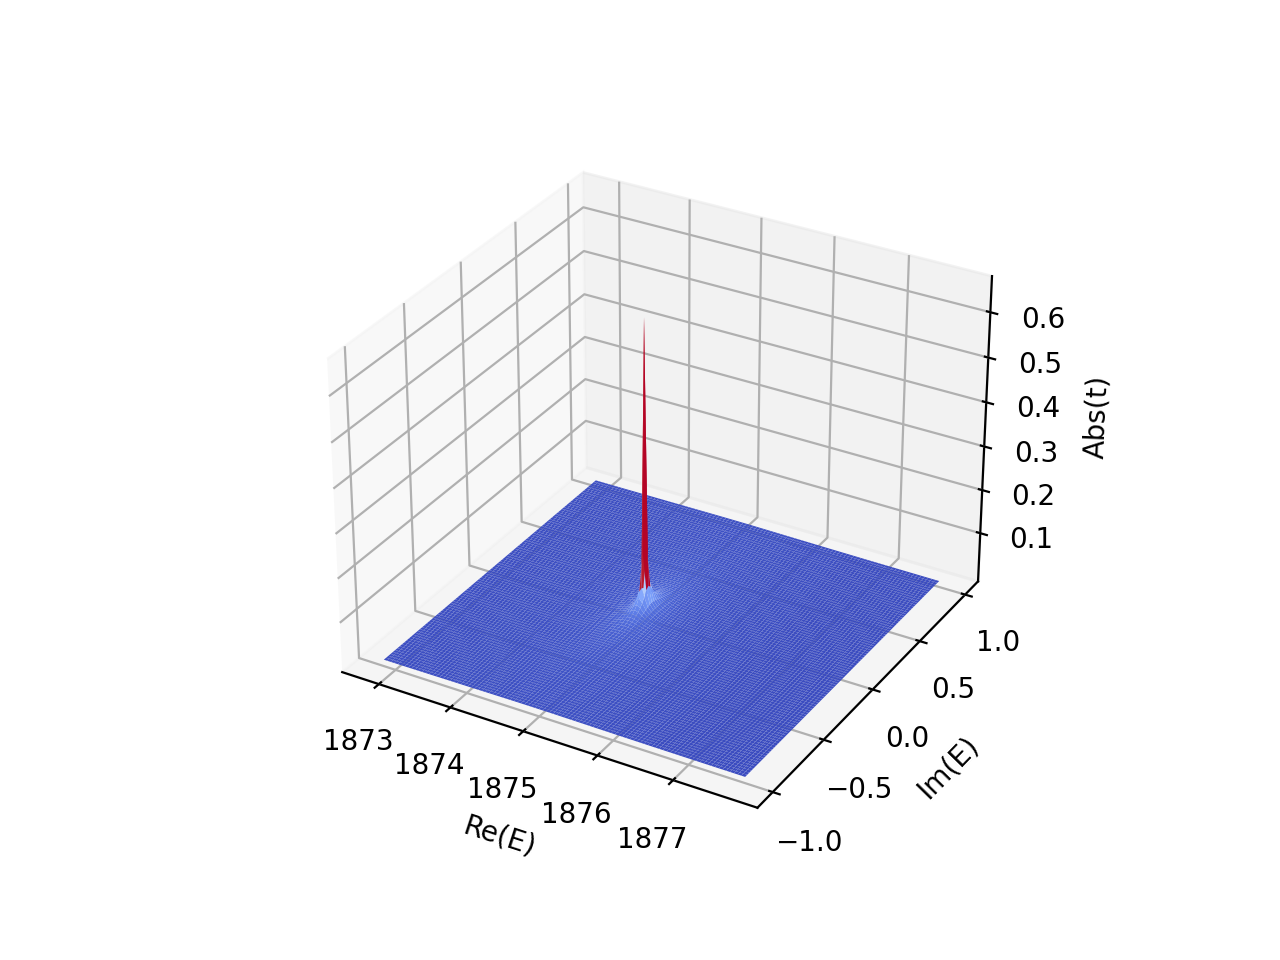

opepCut 1
contour_center (1874.9965+0j)
V [[-0.00022618+0.j]]
G [[-4420.86291107-0.j]]
X
 [[1.+0.j]]
Z
 [[0.-0.j]]
Normalization check (0.9996944743380359+3.7736001036714337e-17j)


In [5]:
opepCut = 1
num_of_ch = 1

para_tmp = [['constant',c0_th*1,c1_th*0,c2_th*0],['form' , 4/np.pi*lambda_cut]]
#para_tmp=para_beta(150)
print(para_tmp)

plot_complex( [[2*mass_N-5,2*mass_N-0.1],[-1,1]], 'erg' , 'T', real_imag = [False,False], show_threshold = False , para = para_tmp, Gtype = 'full',flag_mod=True)
#plt.savefig('pole_structure_dch.png',dpi = 500)
print_X_chs([[2*mass_N-3,2*mass_N-0.1],[-1,1]],para = para_tmp,Gtype='full')
